#### Data Pre-process

In [1]:
from argparse import Namespace
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
### Preprocess functions

def preprocess_text(review):
    review = review.lower() # Convert text to lowercase / case folding
    review = re.sub(r"\d+", "", review) # Remove numbers
    review = re.sub(r'\W', r' ', review) # replace special character strings with empty string
    review = re.sub(r'\s+', r' ', review) # Reduce extra whitespaces between words
    review = review.strip() # Remove leading and ending spaces
    return review

def remove_stopwords(review):
    tokens = word_tokenize(review) # str to tokens
    stop_words = set(stopwords.words('english'))
    tokens = [i for i in tokens if not i in stop_words] # remove stop words
    review = ' '.join(tokens)
    return review

def lemmatization(review):
    tokens = word_tokenize(review)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    review = ' '.join(tokens)
    return review

# remove the post time sentences
def removePostTime(review):
    tokens = word_tokenize(review) # str to tokens
    post_time_words = ['Posted','January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
    tokens = [i for i in tokens if not i in post_time_words] # remove  post time sentences
    review = ' '.join(tokens)
    return review


In [3]:
args = Namespace(                               
    input_munged_csv="review_Details.csv",
    output_munged_csv="review_Details_preprocessed.csv"
)

In [4]:
# review preprocessed data file
df1 = pd.read_csv(args.input_munged_csv)
df1.head()

,gameTitle,Reviews,Rate
0,Back 4 Blood,Posted: 25 October\r\n\t\t\t\t\t\t\t\t\t\t\t\t...,Recommended
1,Back 4 Blood,Posted: 18 October\r\n\t\t\t\t\t\t\t\t\t\t\t\t...,Recommended
2,Back 4 Blood,Posted: 16 October\r\n\t\t\t\t\t\t\t\t\t\t\t\t...,Recommended
3,Back 4 Blood,Posted: 30 October\r\n\t\t\t\t\t\t\t\t\t\t\t\t...,Not Recommended
4,Back 4 Blood,Posted: 12 October\r\n\t\t\t\t\t\t\t\t\t\t\t\t...,Not Recommended


Number of total review: 400
Number of positive review: 301
Number of negetive review: 99


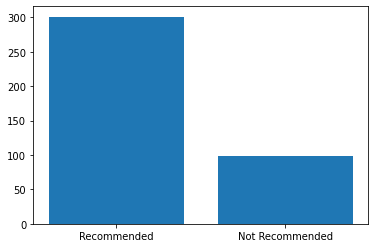

In [5]:
print('Number of total review:', df1['Rate'].count())
print('Number of positive review:', df1[df1['Rate'] == 'Recommended'].count()[0])
print('Number of negetive review:', df1[df1['Rate'] == 'Not Recommended'].count()[0])

plt.bar(['Recommended','Not Recommended'], [df1[df1['Rate'] == 'Recommended'].count()[0],df1[df1['Rate'] == 'Not Recommended'].count()[0]])
plt.show()

In [6]:
# preprocess raw review content
df1.Reviews = df1.Reviews.apply(removePostTime)
df1.Reviews = df1.Reviews.apply(preprocess_text)
df1.Reviews = df1.Reviews.apply(remove_stopwords)
df1.Reviews = df1.Reviews.apply(lemmatization)

In [7]:
# label for Recommended = 1; Not Recommended = 0
df1.Rate = df1.Rate.apply({'Not Recommended':0,'Recommended':1}.get)

In [8]:
# save preprocessed data
df1.to_csv(args.output_munged_csv, index=False)

In [9]:
# review preprocessed data file
df2 = pd.read_csv(args.output_munged_csv).dropna() 
df2.head()

,gameTitle,Reviews,Rate
0,Back 4 Blood,really fun honestly wait sale,1
1,Back 4 Blood,pretty decent current state game double price ...,1
2,Back 4 Blood,need workshop versus campaign game otherwise g...,1
3,Back 4 Blood,waiting moment playing hour completed act recr...,0
4,Back 4 Blood,like game feel like left dead modern fresh rea...,0


#### Text Classification using Scikit-Learn

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Number of total review: 400
Number of positive review: 301
Number of negetive review: 99


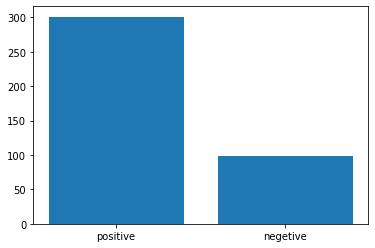

In [11]:
### STEP 1 - Corpus collection

# Load data
seed_number = 1234

df = pd.read_csv(args.output_munged_csv).dropna()   # after reprocessing, some review may become NaN

# Explore data
print('Number of total review:', df['Rate'].count())
print('Number of positive review:', df[df['Rate'] == 1].count()[0])
print('Number of negetive review:', df[df['Rate'] == 0].count()[0])

plt.bar(['positive','negetive'], [df[df['Rate'] == 1].count()[0],df[df['Rate'] == 0].count()[0]])
plt.show()

The number of total data: 400
The number of training data: 360
The number of test data: 40


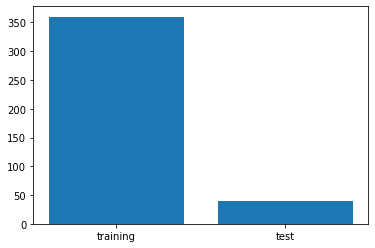

In [12]:
# split data into training and test dataset
# Assign X=> review, y=> label
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['Reviews'], 
                                                            df['Rate'], 
                                                            test_size=0.1, 
                                                            random_state=seed_number, 
                                                            stratify=df['Rate'])
print(f'The number of total data: {len(X_train_raw) + len(X_test_raw)}')
print(f'The number of training data: {len(X_train_raw)}')
print(f'The number of test data: {len(X_test_raw)}')

plt.bar(['training','test'], [len(X_train_raw),len(X_test_raw)])
plt.show()

In [13]:
### Step 2 - Declare Features Vectors 

# Create TfidfVectorizer.
vectorizer = TfidfVectorizer(use_idf=True)

# Fit and transform
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

print('TF-IDF vectors:\n',X_train.todense())
print('Vocabulary:\n',vectorizer.vocabulary_)

TF-IDF vectors:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Vocabulary:
 {'fixed': 2014, 'issue': 2800, 'player': 3891, 'enjoy': 1724, 'game': 2168, 'bought': 610, 'version': 5709, 'played': 3890, 'day': 1273, 'went': 5834, 'go': 2258, 'long': 3078, 'rd': 4203, 'finishing': 1995, 'paper': 3734, 'im': 2608, 'greeted': 2320, 'message': 3246, 'banned': 431, 'ea': 1613, 'website': 5823, 'find': 1988, 'apparently': 249, 'cheating': 818, 'later': 2937, 'found': 2102, 'false': 1920, 'positive': 3943, 'ban': 426, 'razer': 4202, 'synapse': 5215, 'caused': 768, 'appeal': 251, 'thats': 5313, 'never': 3471, 'going': 2262, 'happen': 2397, 'basically': 448, 'got': 2278, 'stolen': 5051, 'thanks': 5312, 'overall': 3684, 'great': 2313, 'story': 5068, 'okay': 3599, 'play': 3888, 'fun': 2145, 'however': 2548, 'three': 5347, 'make': 3139, 'give': 2241, 'negative': 3459, 'review': 4426, 'amount'

In [14]:
### STEP 4 - Prediction

# Create and run Classifier
classifier = LogisticRegression()

# Fitting requires training TF_IDF vectors and labels
classifier.fit(X_train, y_train)

# X_test is the transformed test TF-IDF vectors
predictions = classifier.predict(X_test)

In [15]:
# show test results
print(classification_report(y_test, predictions))  

              precision    recall  f1-score   support

           0       1.00      0.40      0.57        10
           1       0.83      1.00      0.91        30

    accuracy                           0.85        40
   macro avg       0.92      0.70      0.74        40
weighted avg       0.88      0.85      0.82        40



     True  positive  negetive
Predicted                    
positive          4         0
negetive          6        30


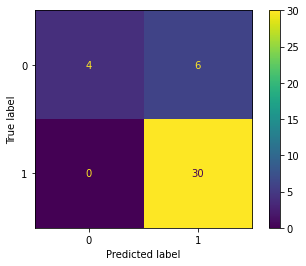

In [16]:
from sklearn.metrics import plot_confusion_matrix
# show confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm.T, index=['positive', 'negetive'], columns=['positive', 'negetive'])
cm_df.index.name = 'Predicted'
cm_df.columns.name = '     True'
print(cm_df)

# Plot non-normalized confusion matrix
plot_confusion_matrix(classifier, X_test, y_test)

In [17]:
### STEP 5 - Evaluation

# cross_val_score: Return the mean accuracy on the given test data and labels.
accuracy = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
precisions = cross_val_score(classifier, X_train, y_train, cv=5, scoring='precision')
recalls = cross_val_score(classifier, X_train, y_train, cv=5, scoring='recall') 
f1s = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')

print('Accuracy:', np.mean(accuracy), accuracy)
print('Precision:', np.mean(precisions), precisions)
print('Recall:', np.mean(recalls), recalls)
print('F1:', np.mean(f1s), f1s)

Accuracy: 0.8305555555555555 [0.86111111 0.79166667 0.81944444 0.84722222 0.83333333]
Precision: 0.8167367480021601 [0.84615385 0.7826087  0.80597015 0.83076923 0.81818182]
Recall: 1.0 [1. 1. 1. 1. 1.]
F1: 0.898968091167126 [0.91666667 0.87804878 0.89256198 0.90756303 0.9       ]


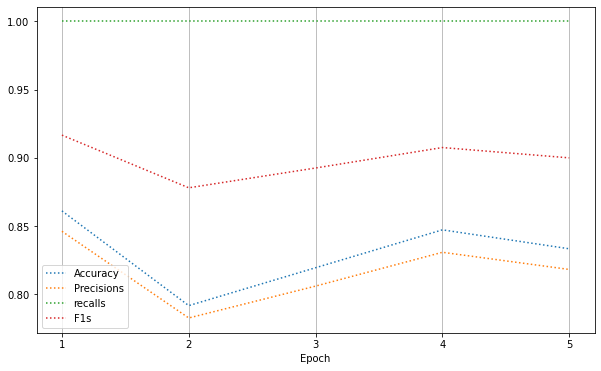

In [18]:
# plot lines of each epoch
plt.figure(figsize=(10,6))
x = [1,2,3,4,5]

plt.plot(x, accuracy, label = "Accuracy", linestyle=":")
plt.plot(x, precisions, label = "Precisions", linestyle=":")
plt.plot(x, recalls, label = "recalls", linestyle=":")
plt.plot(x, f1s, label = "F1s", linestyle=":")

plt.xticks(ticks=x, labels=x)
plt.xlabel("Epoch")
plt.grid(axis='x')
plt.legend()
plt.show()